In [52]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import re
import random
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression

### Read Data

In [53]:
df1 = pd.read_excel('DDS9_Data_Extract_with_labels.xlsx')
df2 = pd.read_excel('DDS10_Data_Extract_with_labels.xlsx')
df3 = pd.read_excel('DDS11_Data_Extract_with_labels.xlsx')

### Concatenated dataset for the common columns

In [54]:
df1cols = set(df1.columns)
df2cols = set(df2.columns)
df3cols = set(df3.columns)
common_cols = list(df1cols.intersection(df2cols).intersection(df3cols))
#print(len(common_cols))
merged_df = pd.concat([df1[common_cols], df2[common_cols], df3[common_cols]], ignore_index=True)
#merged_df

In [55]:
#print(df1.columns)

### Model 1: Relationship between household income and media/home entertainment equipment owned by a household

In [56]:
# Renaming column names for modeling
df1 = df1.rename(columns={
    "Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential.": "household_income",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR)": "DVR_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television": "FlatTV_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box": "MediaBox_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob": "Fob_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player": "DVD_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console": "GamingCon_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player": "PortableGame_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Computer network/router in your home for wireless computer/laptop usage": "Router_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Desktop computer": "Desktop_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop computer": "Laptop_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop/tablet hybrid": "LapTabHybrid_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Tablet (nine inches and above)": "Tab9in_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Small tablet (between seven and nine inches)": "Tab7_9in_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Dedicated e-book reader": "EbookReader_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Smartphone (three to five inches)": "Smartphone3_5in_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Large smartphone (between five and seven inches)": "LargeSmartphone_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Basic mobile phone (not a smartphone)": "BasicMobile_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Smart watch": "Smartwatch_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Fitness band": "FitnessBand_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Smart glasses": "SmartGlasses_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-3D printer": "3DPrinter_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-None of the above": "None_owned",
    "Q8 - Which of the following media or home entertainment equipment does your household own?-Don't Know": "DontKnow_owned",
    "Q36r1 - Pay TV (cable and/or satellite) - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the o" : "PayTV",
    "Q36r2 - Home internet - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the order you wish to r": "HomeInternet",
    "Q36r3 - Landline telephone - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the order you wish": "LandlineTelephone",
    "Q36r4 - Mobile voice - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the order you wish to ra": "MobileVoice",
    "Q36r5 - Mobile data plan - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the order you wish t": "MobileDataPlan",
    "Q36r6 - Streaming video service  - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selec": "StreamingVideoService",
    "Q36r7 - Streaming music service  - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking e": "StreamingMusicService",
    "Q36r8 - Gaming - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicki": "Gaming",
    "Q36r9 - News/Newspaper (print or digital) - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the": "News/Newspaper",
    "Q36r10 - Magazine (print or digital) - Of the services you indicated your household purchases, which [totalcount] do you value the most?Please rank the top [totalcount], with \"1\" being the most valued. Make your selections by clicking each item in the orde": "Magazine",
    "Q1r1 - To begin, what is your age?": "Age",
    "Q2 - In which state do you currently reside?": "State",
    "QNEW3 - What is your employment status?": "EmploymentStatus",
    "Q4 - What is your gender?": "Gender",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Flat panel television":"FlatTV_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Digital video recorder (DVR)":"DVR_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Streaming media box or over-the-top box":"StreamingMediaBox_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Portable streaming thumb drive/fob":"PortableDevice_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Over-the-air digital TV antenna (for free access to network broadcast without pay TV subscription)":"DigitalTVAntenna_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Blu-ray disc player/DVD player":"Blu-ray_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Gaming console": "GamingConsole_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Portable video game player": "PortableGamePlayer_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Computer network/router in your home for wireless computer/laptop usage": "Router_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Desktop computer": "DesktopComputer_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Laptop computer": "LaptopComputer_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Tablet": "Tablet_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Dedicated e-book reader": "EbookReader_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Smartphone": "Smartphone_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Basic mobile phone": "BasicMobile_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Smart watch": "Smartwatch_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Fitness band": "FitnessBand_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Virtual reality headset": "VRHeadset_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Drone": "Drone_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-None of the above": "None_Future",
    "Q10 - Of those products you indicated you do not currently own, which of the following do you plan to purchase in the next 12 months?-Don't Know": "DontKnow_Future"

    
    
})

print(df1.columns)


Index(['record - Record number', 'Age', 'Gender', 'age - you are...', 'State',
       'region - Region', 'EmploymentStatus',
       'Q5 - Which category best describes your ethnicity?',
       'QNEW1 - Do you have children living in your home (excluding yourself if you are under 18)?',
       'QNEW2 - How old are the children in your home?-0-4 years',
       ...
       'Q73r10 - Talk on the phone - Which are things you typically do while watching your home television system?',
       'Q73r11 - Browse for products and services online - Which are things you typically do while watching your home television system?',
       'Q73r12 - Purchase products and services online - Which are things you typically do while watching your home television system?',
       'Q73r13 - Play video games - Which are things you typically do while watching your home television system?',
       'Q39r1 - I would rather pay for online content (news, information, sports, games, social interaction sites, movies, mus

In [57]:

income_equipment_data = df1[['household_income', 'DVR_owned', 'FlatTV_owned', 'MediaBox_owned','Fob_owned','DVD_owned','GamingCon_owned','PortableGame_owned','Router_owned',
'Desktop_owned','Laptop_owned','LapTabHybrid_owned','Tab9in_owned','Tab7_9in_owned','EbookReader_owned','Smartphone3_5in_owned','LargeSmartphone_owned', 'BasicMobile_owned', 'Smartwatch_owned','FitnessBand_owned','SmartGlasses_owned','3DPrinter_owned','None_owned','DontKnow_owned']]

income_mapping = {
    'Less than $29,999': 1,
    '$30,000 to $49,999': 2,
    '$50,000 to $99,999': 3,
    '$100,000 to $299,999': 4,
    'More than $300,000': 5,
    'Do not know': 0
}

income_equipment_data['Income_Num'] = income_equipment_data['household_income'].map(income_mapping)

one_hot_encoded = pd.get_dummies(income_equipment_data['Income_Num'], prefix='Income')

income_equipment_data = pd.concat([income_equipment_data, one_hot_encoded], axis=1)


equipment_columns = ['DVR_owned', 'FlatTV_owned', 'MediaBox_owned', 'Fob_owned', 'DVD_owned', 'GamingCon_owned', 'PortableGame_owned', 'Router_owned',
    'Desktop_owned', 'Laptop_owned', 'LapTabHybrid_owned', 'Tab9in_owned', 'Tab7_9in_owned', 'EbookReader_owned', 'Smartphone3_5in_owned', 'LargeSmartphone_owned', 
    'BasicMobile_owned', 'Smartwatch_owned', 'FitnessBand_owned', 'SmartGlasses_owned', '3DPrinter_owned', 'None_owned', 'DontKnow_owned']


for column in equipment_columns:
    income_equipment_data[column] = income_equipment_data[column].map({'Yes': 1, 'No': 0})

income_equipment_data.drop('household_income', axis=1, inplace=True)


/var/folders/_5/kctvxtcx61x5gst0123hf5x00000gn/T/ipykernel_56178/4064711935.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_equipment_data['Income_Num'] = income_equipment_data['household_income'].map(income_mapping)


In [58]:
## Importance Dataset
important_equipments = ['PayTV','HomeInternet','LandlineTelephone','MobileVoice','MobileDataPlan','StreamingVideoService','StreamingMusicService','Gaming','News/Newspaper','Magazine']

In [59]:
df_mapped = df1[important_equipments]

In [60]:
df_mapped = df_mapped.fillna(0)
df_mapped

,PayTV,HomeInternet,LandlineTelephone,MobileVoice,MobileDataPlan,StreamingVideoService,StreamingMusicService,Gaming,News/Newspaper,Magazine
0,0.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0
3,0.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2071,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2072,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
2073,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
2074,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


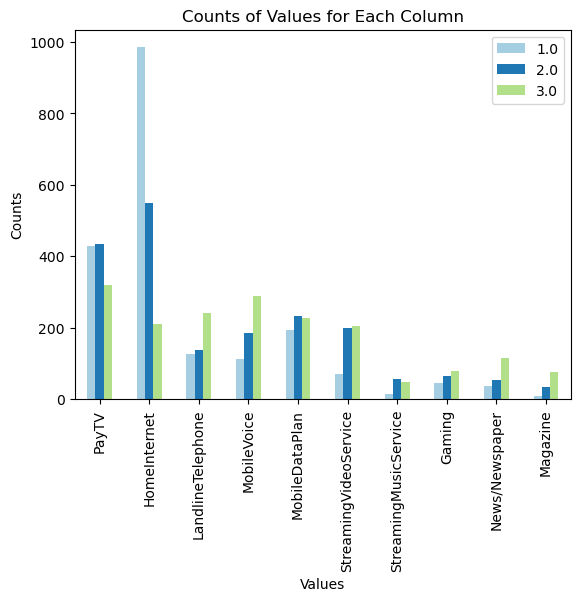

In [61]:
counts = df_mapped.apply(lambda x: x.value_counts())[1:].transpose()

colors = plt.cm.Paired(range(len(important_equipments)+1))

ax = counts.plot(kind='bar', stacked=False, color=colors)
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values for Each Column')

plt.show() 

## TV

In [62]:
## TV ownership prediction based on demographics 
## df1

In [63]:
df_sampled = df1[['Age', 'Gender', 'State', 'EmploymentStatus', 'FlatTV_owned']]

In [64]:
#df_sampled

In [65]:
income = income_equipment_data[['Income_0','Income_1','Income_2','Income_3','Income_4','Income_5']]

In [66]:
merged_df = pd.merge(df_sampled, income, left_index=True, right_index=True)

In [67]:
#merged_df

In [68]:
 merged_df['FlatTV_owned'] = merged_df['FlatTV_owned'].map({'Yes': 1, 'No': 0})

In [69]:
categorical_columns = ['Age', 'Gender', 'State', 'EmploymentStatus']

df_encoded = pd.get_dummies(merged_df, columns=categorical_columns)

#print(df_encoded)

In [70]:
## Logistic Regression

X = df_encoded.drop(['FlatTV_owned'], axis=1) 
y = df_encoded['FlatTV_owned']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7307692307692307
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.04      0.07       104
           1       0.75      0.96      0.84       312

    accuracy                           0.73       416
   macro avg       0.50      0.50      0.45       416
weighted avg       0.62      0.73      0.65       416



In [71]:
coefficients = model.coef_[0]
feature_names = X.columns


coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

print(coefficients_df)


                            Feature  Coefficient  Absolute Coefficient
25                           Age_33     1.184142              1.184142
129                  State_Virginia    -0.968791              0.968791
63                           Age_71    -0.881510              0.881510
112             State_New Hampshire    -0.835900              0.835900
69                           Age_77    -0.813145              0.813145
..                              ...          ...                   ...
56                           Age_64    -0.031982              0.031982
136  EmploymentStatus_Self-employed    -0.020719              0.020719
131             State_West Virginia     0.012573              0.012573
133                   State_Wyoming    -0.011269              0.011269
23                           Age_31     0.006428              0.006428

[139 rows x 3 columns]


In [72]:
tv_probabilities = model.predict_proba(X)[:, 1]

df_tv_ownership = pd.DataFrame({
    'State': df_encoded.filter(regex='^State_', axis=1).idxmax(axis=1),
    'Income': df_encoded.filter(regex='^Income_', axis=1).idxmax(axis=1),
    'Gender': df_encoded.filter(regex='^Gender_', axis=1).idxmax(axis=1),
    'Age': df_encoded.filter(regex='^Age_', axis=1).idxmax(axis=1),
    'EmploymentStatus': df_encoded.filter(regex='^EmploymentStatus_', axis=1).idxmax(axis=1),
    'Probability_TV_Owned': tv_probabilities
})

# Filter rows where TV is owned (probability greater than 0.5)
tv_owned_df = df_tv_ownership[df_tv_ownership['Probability_TV_Owned'] > 0.5]

# Grouped by state to find the top 10 states with the highest TV ownership probabilities
top_states = tv_owned_df.groupby('State')['Probability_TV_Owned'].mean().sort_values(ascending=False).head(10).index

top_states_df = tv_owned_df[tv_owned_df['State'].isin(top_states)]

# Top 10 states, along with incomes, genders, and age groups
result_df = top_states_df[['State', 'Income', 'Gender', 'Age', 'EmploymentStatus']].groupby('State').first()
print(result_df)


                              Income         Gender     Age  \
State                                                         
State_Alabama               Income_1  Gender_Female  Age_25   
State_Delaware              Income_3  Gender_Female  Age_29   
State_District of Columbia  Income_1    Gender_Male  Age_50   
State_Florida               Income_4    Gender_Male  Age_68   
State_Indiana               Income_1  Gender_Female  Age_24   
State_Maine                 Income_3    Gender_Male  Age_39   
State_Minnesota             Income_1    Gender_Male  Age_31   
State_Missouri              Income_1    Gender_Male  Age_43   
State_Oregon                Income_3    Gender_Male  Age_43   
State_South Carolina        Income_3  Gender_Female  Age_27   

                                                            EmploymentStatus  
State                                                                         
State_Alabama               EmploymentStatus_Employed full-time or part-time  
State_

In [73]:
### Decision Trees

X = df_encoded.drop(['FlatTV_owned'], axis=1) 
y = df_encoded['FlatTV_owned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.6875
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.23      0.27       104
           1       0.77      0.84      0.80       312

    accuracy                           0.69       416
   macro avg       0.55      0.54      0.54       416
weighted avg       0.66      0.69      0.67       416



## Home Internet

In [74]:
encoded_columns_q26 = {
    "Q26 - Which of the following subscriptions does your household purchase?-Pay TV (cable and/or satellite)": "PayTV_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Home internet": "HomeInternet_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Landline telephone": "LandlineTelephone_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Mobile voice (smartphone or basic mobile phone calling plan)": "MobileVoice_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Mobile data plan": "MobileDataPlan_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Streaming video service": "StreamingVideoService_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Streaming music service": "StreamingMusicService_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Gaming": "Gaming_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-News/Newspaper (print or digital)": "News/Newspaper_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Magazine (print or digital)": "Magazine_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-None of the above": "None_Subscription",
    "Q26 - Which of the following subscriptions does your household purchase?-Don't Know": "DontKnow_Subscription"
}

df1 = df1.rename(columns=encoded_columns_q26)


In [75]:
df1['PayTV_Subscription']

0        No
1        No
2       Yes
3       Yes
4        No
       ... 
2071     No
2072    Yes
2073    Yes
2074    Yes
2075    Yes
Name: PayTV_Subscription, Length: 2076, dtype: object

In [76]:
subscription_columns = df1[['PayTV_Subscription',
    'HomeInternet_Subscription',
    'LandlineTelephone_Subscription',
    'MobileVoice_Subscription',
    'MobileDataPlan_Subscription',
    'StreamingVideoService_Subscription',
    'StreamingMusicService_Subscription',
    'Gaming_Subscription',
    'News/Newspaper_Subscription',
    'Magazine_Subscription',
    'None_Subscription',
    'DontKnow_Subscription']]

In [77]:
subscription_mapping = {'Yes': 1, 'No': 0}

for column in subscription_columns:
    df1[column] = df1[column].map(subscription_mapping)

In [78]:
df1['Gaming_Subscription']

0       0
1       0
2       1
3       0
4       0
       ..
2071    0
2072    0
2073    0
2074    0
2075    1
Name: Gaming_Subscription, Length: 2076, dtype: int64

In [79]:
# Whether a respondent subscribes to home internet

In [80]:
df_sampled = df1[['Age', 'Gender', 'State', 'EmploymentStatus', 'PayTV_Subscription',
    'HomeInternet_Subscription',
    'LandlineTelephone_Subscription',
    'MobileVoice_Subscription',
    'MobileDataPlan_Subscription',
    'StreamingVideoService_Subscription',
    'StreamingMusicService_Subscription',
    'Gaming_Subscription',
    'News/Newspaper_Subscription',
    'Magazine_Subscription',
    'None_Subscription',
    'DontKnow_Subscription']]

In [81]:
merged_df = pd.merge(df_sampled, income, left_index=True, right_index=True)

In [82]:
merged_df

,Age,Gender,State,EmploymentStatus,PayTV_Subscription,HomeInternet_Subscription,LandlineTelephone_Subscription,MobileVoice_Subscription,MobileDataPlan_Subscription,StreamingVideoService_Subscription,...,News/Newspaper_Subscription,Magazine_Subscription,None_Subscription,DontKnow_Subscription,Income_0,Income_1,Income_2,Income_3,Income_4,Income_5
0,28,Female,California,Unemployed,0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,33,Female,New York,Unemployed,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,24,Male,Nevada,Employed full-time or part-time,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
3,51,Female,New Jersey,Self-employed,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,1,0
4,20,Male,Arkansas,Unemployed,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071,73,Male,Florida,Retired,0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2072,27,Male,California,Employed full-time or part-time,1,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
2073,29,Male,Texas,Employed full-time or part-time,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
2074,25,Male,Vermont,Employed full-time or part-time,1,1,1,1,1,0,...,1,1,0,0,0,0,0,0,1,0


In [83]:
categorical_columns = ['Age', 'Gender', 'State', 'EmploymentStatus']

df_encoded = pd.get_dummies(merged_df, columns=categorical_columns)

print(df_encoded)

      PayTV_Subscription  HomeInternet_Subscription  \
0                      0                          1   
1                      0                          0   
2                      1                          1   
3                      1                          1   
4                      0                          1   
...                  ...                        ...   
2071                   0                          1   
2072                   1                          1   
2073                   1                          1   
2074                   1                          1   
2075                   1                          0   

      LandlineTelephone_Subscription  MobileVoice_Subscription  \
0                                  0                         0   
1                                  0                         0   
2                                  0                         1   
3                                  1                         1   
4        

In [84]:
## Decision Tree

X = df_encoded.drop(['HomeInternet_Subscription'], axis=1)
y = df_encoded['HomeInternet_Subscription']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42)


clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.8606
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.37      0.34        41
           1       0.93      0.91      0.92       375

    accuracy                           0.86       416
   macro avg       0.62      0.64      0.63       416
weighted avg       0.87      0.86      0.86       416



In [85]:
## Logistic Regression


X = df_encoded.drop(['HomeInternet_Subscription'], axis=1) 
y = df_encoded['HomeInternet_Subscription']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.9110576923076923
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.27      0.37        41
           1       0.92      0.98      0.95       375

    accuracy                           0.91       416
   macro avg       0.77      0.62      0.66       416
weighted avg       0.89      0.91      0.90       416



In [86]:

coefficients = model.coef_[0]
feature_names = X.columns
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})


coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

print(coefficients_df)


                            Feature  Coefficient  Absolute Coefficient
9                 None_Subscription    -2.913922              2.913922
31                           Age_28    -1.340341              1.340341
34                           Age_31    -1.317817              1.317817
20                           Age_17     1.273543              1.273543
1    LandlineTelephone_Subscription     1.134422              1.134422
..                              ...          ...                   ...
101                  State_Delaware     0.024427              0.024427
77                           Age_74     0.023376              0.023376
40                           Age_37     0.023346              0.023346
41                           Age_38    -0.000646              0.000646
10            DontKnow_Subscription     0.000000              0.000000

[150 rows x 3 columns]


In [87]:
tv_probabilities = model.predict_proba(X)[:, 1]


df_tv_ownership = pd.DataFrame({
    'State': df_encoded.filter(regex='^State_', axis=1).idxmax(axis=1),
    'Income': df_encoded.filter(regex='^Income_', axis=1).idxmax(axis=1),
    'Gender': df_encoded.filter(regex='^Gender_', axis=1).idxmax(axis=1),
    'Age': df_encoded.filter(regex='^Age_', axis=1).idxmax(axis=1),
    'EmploymentStatus': df_encoded.filter(regex='^EmploymentStatus_', axis=1).idxmax(axis=1),
    'Probability_TV_Owned': tv_probabilities
})


tv_owned_df = df_tv_ownership[df_tv_ownership['Probability_TV_Owned'] > 0.5]

# Grouped these by state to find the top 10 states with the highest TV ownership probabilities
top_states = tv_owned_df.groupby('State')['Probability_TV_Owned'].mean().sort_values(ascending=False).head(10).index

# Filtered the DataFrame for the top 10 states
top_states_df = tv_owned_df[tv_owned_df['State'].isin(top_states)]

# Top 10 states, along with incomes, genders, and age groups
result_df = top_states_df[['State', 'Income', 'Gender', 'Age', 'EmploymentStatus']].groupby('State').first()
print(result_df)


                              Income         Gender     Age  \
State                                                         
State_Alaska                Income_3  Gender_Female  Age_53   
State_Delaware              Income_3  Gender_Female  Age_29   
State_District of Columbia  Income_1    Gender_Male  Age_50   
State_Indiana               Income_3    Gender_Male  Age_51   
State_Michigan              Income_2  Gender_Female  Age_52   
State_Montana               Income_2    Gender_Male  Age_58   
State_New Hampshire         Income_2  Gender_Female  Age_22   
State_Pennsylvania          Income_2    Gender_Male  Age_66   
State_Rhode Island          Income_0  Gender_Female  Age_70   
State_Wyoming               Income_1    Gender_Male  Age_52   

                                                            EmploymentStatus  
State                                                                         
State_Alaska                EmploymentStatus_Employed full-time or part-time  
State_